### 1. Load data from kaggle API and unzip data
- Users do need to have access to the original dataset from this competition and place the kaggle key in the folder.


In [0]:
!pip install kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/data"
#changing the working directory
%cd /content/drive/My\ Drive/data

In [0]:
#Check the present working directory using pwd command
%pwd
!kaggle datasets download navjotk/the-identification-game

In [0]:
!unzip the-identification-game.zip

#### 2.Load the image data into Dataset


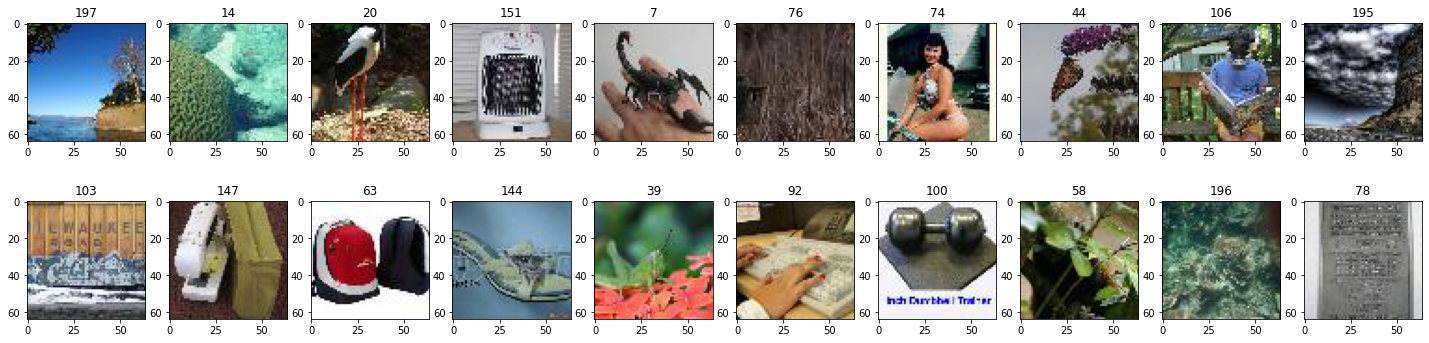

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
%matplotlib inline
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
train_datasets = datasets.ImageFolder(root= "train", transform=ToTensor())
train_dataloader = DataLoader(train_datasets, batch_size=64, shuffle=True, num_workers=2)
    
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
labels = labels.numpy()
images = images.numpy()
fig = plt.figure(figsize=(25, 6))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1)#, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx], fontsize=12)

### 3.Prepara the data in tensor form and save them for quicker training access
- easier to split 
- quicker to load
- need large ram

In [0]:
X_train_all = torch.zeros(100000, 3, 64, 64)
y_train_all = torch.zeros(100000)
for idx in range(100000):
  X_train_all[idx], y_train_all[idx] = train_datasets[idx][0], train_datasets[idx][1]

In [0]:
torch.save(X_train_all, 'X_train_all.pt')
torch.save(y_train_all, 'y_train_all.pt')

In [0]:
# calculate the mean and std for each channel over the test dataset
mean_list = X_train_all.mean(axis=(0,2,3))
std_list = X_train_all.std(axis=(0,2,3))
torch.save(mean_list, 'mean_list.pt')
torch.save(std_list, 'std_list.pt')

In [0]:
test_datasets = datasets.ImageFolder(root= "test", transform=ToTensor())
X_test = torch.zeros(10000, 3, 64, 64)
for idx in range(10000):
  X_test[idx] = test_datasets[idx][0]

In [0]:
torch.save(X_test, 'X_test.py')

#### **Prepare the output from pretrianed model


In [0]:
X_train_all = torch.load('/content/drive/My Drive/data/X_train_all.py') # all images in train file
y_train_all = torch.load('/content/drive/My Drive/data/y_train_all.py') # all labels in train file
mean_list = torch.load('/content/drive/My Drive/data/mean_list.py') # mean
std_list = torch.load('/content/drive/My Drive/data/std_list.py') # std of 3 channels
X_test = torch.load('/content/drive/My Drive/data/X_test.py') # all images in test file

In [0]:
from torch.utils.data import Dataset
from PIL import Image

# Custom Dataset for performing Stratified Shuffle Split on ImageFolder datasets

class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            dataset: an ImageFolder containing the full set of data to be subsampled
            indices: array-like containing the stratified shuffle indices
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # Note that samples are just paths to image files
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [0]:
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            y_pred = F.log_softmax(a2, dim=1)
            #print(y_pred)
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [0]:
from torchvision.transforms import *

train_transform = Compose([ToPILImage(),
              transforms.Resize(224),
              ToTensor(),
              Normalize(mean_list, std_list)])

#In Validation and Test Mode we only want to normalize our images


In [0]:
train_all_data = CustomDataset(X_train_all, y_train_all.long(), transform=train_transform)
batch_size = 100
train_all_loader = torch.utils.data.DataLoader(train_all_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [0]:
empyty_y = torch.zeros(10000)
test_dataset = CustomDataset(X_test, empyty_y.long(), transform=train_transform)
batch_size = 100
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [0]:
vgg19_bn = models.vgg19_bn(pretrained=True)
resnet50 = models.resnet50(pretrained=True)
vgg16_bn = models.vgg16_bn(pretrained=True)
densenet161 = models.densenet161(pretrained=True)
wideResnet = models.wide_resnet50_2(pretrained=True)
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
effNet = EfficientNet.from_pretrained('efficientnet-b7')

In [0]:
X_vgg19, y_vgg19 = evaluate(vgg19_bn.to(device), train_all_loader)
X_resnet50,y_resnet50 = evaluate(resnet50.to(device), train_all_loader)
X_vgg16, y_vgg16 = evaluate(vgg16_bn.to(device), train_all_loader)
X_effNet, y_effNet = evaluate(effNet.to(device), train_all_loader)
X_dense161, y_dense161 = evaluate(densenet161.to(device), train_all_loader)
X_wideRes, y_wideRes = evaluate(wideResnet.to(device), train_all_loader)

In [0]:
X_all_model = np.array((X_vgg16, X_vgg19, X_resnet50, X_effNet, X_dense161, X_wideRes))
X_all_pre = numpy.empty((100000,6000))
for num in range(100000):
  for feature in range(1000):
    for mod in range(6):
      X_all_pre[num][mod*1000+feature] = X_all_model[mod][num][feature]X_train_all
X_all_prob =  np.exp(X_all_pre)
torch.save(torch.from_numpy(X_all_prob),'X_all_prob.pt')
torch.save(torch.from_numpy(y_vgg19),'y_all_pre.pt')

In [0]:
X_vgg19, y_vgg19 = evaluate(vgg19_bn.to(device), test_loader)
X_resnet50,y_resnet50 = evaluate(resnet50.to(device), test_loader)
X_vgg16, y_vgg16 = evaluate(vgg16_bn.to(device), test_loader)
X_effNet, y_effNet = evaluate(effNet.to(device), test_loader)
X_dense161, y_dense161 = evaluate(densenet161.to(device), test_loader)
X_wideRes, y_wideRes = evaluate(wideResnet.to(device), test_loader)

In [0]:
X_all_model = np.array((X_vgg16, X_vgg19, X_resnet50, X_effNet, X_dense161, X_wideRes))
X_all_pre = numpy.empty((100000,6000))
for num in range(100000):
  for feature in range(1000):
    for mod in range(6):
      X_all_pre[num][mod*1000+feature] = X_all_model[mod][num][feature]X_train_all
X_all_prob =  np.exp(X_all_pre)
torch.save(torch.from_numpy(X_all_prob),'X_test_prob.pt')